In [20]:
# ===== Packages =====

import pandas as pd
import numpy as np

import joblib
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.base import clone

from matplotlib import pyplot as plt

plt.style.use("classic")
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "text.latex.preamble": r"\usepackage{ebgaramond}",
    }
)


In [21]:
# ===== Data Load =====
df_mdl = pd.read_csv("OnlineRetail_clean.csv")

df_mdl


,Date,StockCode,Country,Description,Quantity,revenue,UnitPrice,month,DoM,DoW,stock_age_days,sku_avg_p,LnP,LnQ,dLnP,dLnQ
0,2010-12-01,10002,France,INFLATABLE POLITICAL GLOBE,48,40.80,0.85,12,1,2,0,0.850000,-0.162519,3.871201,-0.173158,1.046094
1,2010-12-01,10002,United Kingdom,INFLATABLE POLITICAL GLOBE,12,10.20,0.85,12,1,2,0,0.850000,-0.162519,2.484907,-0.173158,-0.340200
2,2010-12-01,10125,United Kingdom,MINI FUNKY DESIGN TAPES,2,1.70,0.85,12,1,2,0,0.850000,-0.162519,0.693147,-0.015594,-2.211211
3,2010-12-01,10133,United Kingdom,COLOURING PENCILS BROWN TUBE,5,4.25,0.85,12,1,2,0,0.659667,-0.162519,1.609438,0.257981,-1.615385
4,2010-12-01,10135,United Kingdom,COLOURING PENCILS BROWN TUBE,1,2.51,2.51,12,1,2,0,1.250000,0.920283,0.000000,0.551839,-2.918686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294521,2011-12-09,90202C,United Kingdom,GREEN ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,367,2.950000,1.064711,0.000000,-0.010554,-0.430783
294522,2011-12-09,90202D,United Kingdom,PINK ENAMEL FLOWER HAIR TIE,1,2.90,2.90,12,9,4,357,2.900000,1.064711,0.000000,-0.005003,-0.693147
294523,2011-12-09,90206C,United Kingdom,CRYSTAL DIAMANTE STAR BROOCH,1,4.98,4.98,12,9,4,373,4.980000,1.605430,0.000000,-0.002490,-0.461346
294524,2011-12-09,90208,United Kingdom,PAIR OF PINK FLOWER CLUSTER SLIDE,1,2.48,2.48,12,9,4,368,2.480000,0.908259,0.000000,-0.007461,-0.414944


In [22]:
# ===== Robust: Binned OLS =====

def binned_ols(
    df,
    x,
    y,
    n_bins,
    plot=True,
    plot_title="",
    plot_ax=None,
    color="blue",
    label=None,
    **plt_kwargs,
):

    df = df.copy()

    # 1. 数据分箱与聚合
    x_bin = x + "_bin"
    # 使用 duplicates='drop' 防止分箱边界重叠报错
    df[x_bin] = pd.qcut(df[x], n_bins, duplicates="drop")

    tmp = df.groupby(x_bin, observed=True).agg({x: "mean", y: "mean"}).dropna()

    # 2. OLS 回归拟合
    mdl = sm.OLS(tmp[y], sm.add_constant(tmp[x]))
    res = mdl.fit()

    # 3. 绘图逻辑
    if plot:
        if plot_ax is None:
            fig, plot_ax = plt.subplots(figsize=(6, 4))

        # 处理 alpha 参数
        user_alpha = plt_kwargs.pop("alpha", None)
        scatter_alpha = user_alpha if user_alpha is not None else 0.4
        line_alpha = user_alpha if user_alpha is not None else 1.0

        # A. 绘制散点
        plot_ax.scatter(
            tmp[x], tmp[y], color=color, alpha=scatter_alpha, s=30, **plt_kwargs
        )

        # B. 绘制拟合曲线
        x_pred = tmp[x].sort_values()
        y_pred = res.predict(sm.add_constant(x_pred))

        plot_ax.plot(
            x_pred,
            y_pred,
            color=color,
            linestyle="--",
            linewidth=2,
            label=label,
            alpha=line_alpha,
        )

        if plot_title:
            plot_ax.set_title(plot_title)

    del df[x_bin]
    return res


In [23]:
# ===== Robust: 计算弹性系数 =====
def estimate_elasticity_binned(t_res, y_res, t, n_bins=15):
    # 1. 构造临时 DataFrame 以便分组
    df_temp = pd.DataFrame({"t_res": t_res, "y_res": y_res, "t_raw": t})

    # 2. 分箱 (Binning)
    # 根据价格残差 (t_res) 进行等频分箱
    # duplicates='drop' 处理大量 0 值的情况

    df_temp["bin"] = pd.qcut(df_temp["t_res"], q=n_bins, duplicates="drop")

    # 3. 聚合 (Aggregation) -> 得到 K 个均值点
    bin_stats = df_temp.groupby("bin", observed=True).mean()

    # 提取聚合后的向量
    t_res_bar = bin_stats["t_res"].values
    y_res_bar = bin_stats["y_res"].values
    t_raw_bar = bin_stats["t_raw"].values

    # 4. 计算弹性 (基于均值点)

    # 分子: Cov(Mean_Res_T, Mean_Res_Y)
    numerator = np.dot(t_res_bar, y_res_bar)

    # 分母 1: Robust DML -> Cov(Mean_Res_T, Mean_Original_T)
    # 逻辑：利用"箱内的平均原始价格"来修正分母
    denom_robust = np.dot(t_res_bar, t_raw_bar)
    theta_robust = numerator / denom_robust if denom_robust != 0 else np.nan

    # 分母 2: Naive DML -> Var(Mean_Res_T)
    denom_naive = np.dot(t_res_bar, t_res_bar)
    theta_naive = numerator / denom_naive if denom_naive != 0 else np.nan

    return theta_robust, theta_naive


In [24]:
# ===== Robust: 单折 =====
def _process_single_fold(df_train, df_test, model_t, model_y, col_t, col_y):
    """
    在单折数据上：训练模型 -> 预测 -> 计算残差
    """
    # 1. 克隆模型
    model_t_fold = clone(model_t)
    model_y_fold = clone(model_y)

    # 2. 训练
    model_t_fold.fit(df_train, df_train[col_t])
    model_y_fold.fit(df_train, df_train[col_y])

    # 3. 预测与残差计算
    pred_t = model_t_fold.predict(df_test)
    pred_y = model_y_fold.predict(df_test)

    resid_t = df_test[col_t] - pred_t
    resid_y = df_test[col_y] - pred_y

    return resid_t, resid_y



In [25]:

# ==============================================================================
# Main Function: 主流程控制
# ==============================================================================
def dml_cross_fitting(
    df: pd.DataFrame,
    model_x,
    model_y,
    col_treatment="dLnP",
    col_outcome="dLnQ",
    n_splits=2,
    random_state=42,
):
    """
    执行 DML Cross-Fitting 的主函数。

    Args:
        df: 包含数据的 DataFrame
        model_x: 预测处理变量(价格)的模型
        model_y: 预测结果变量(销量)的模型
        col_treatment: 处理变量的列名
        col_outcome: 结果变量的列名
    """

    # 存储结果容器
    results_robust = []  # Robust DML estimates
    results_naive = []  # Naive DML estimates
    dfs_residuals = []  # 用于存储带有残差的数据片段

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    print(f"{'=' * 10} Starting DML (k={n_splits}) {'=' * 10}")

    for fold_id, (idx_train, idx_inf) in enumerate(kf.split(df), 1):
        # 1. 数据切分
        df_train = df.iloc[idx_train]
        df_inf = df.iloc[idx_inf].copy()  # Inference set

        # 2. 核心计算：训练模型并获取残差
        resid_t, resid_y = _process_single_fold(
            df_train, df_inf, model_x, model_y, col_treatment, col_outcome
        )

        # 3. 存储残差 (用于后续绘图和全局 MSE 计算)
        df_inf = df_inf.assign(
            resid_treatment=resid_t,  # 对应之前的 dLnP_res
            resid_outcome=resid_y,  # 对应之前的 dLnQ_res
            Fold_ID=fold_id,
        )
        dfs_residuals.append(df_inf)

        # 4. 核心计算：估算弹性系数
        theta_robust, theta_naive = estimate_elasticity_binned(
            t_res=resid_t,
            y_res=resid_y,
            t=df_inf[col_treatment],
            n_bins=15,  # 保持与绘图一致
        )

        results_robust.append(theta_robust)
        results_naive.append(theta_naive)

        print(f"[Fold {fold_id}] Robust: {theta_robust:.4f} | Naive: {theta_naive:.4f}")

    # --- 汇总结果 ---
    df_final_res = pd.concat(dfs_residuals, axis=0)
    avg_theta_robust = np.nanmean(results_robust)
    avg_theta_naive = np.nanmean(results_naive)

    # 计算 RMSE
    # y_true = resid_outcome
    # y_pred = resid_treatment * theta
    global_rmse = np.sqrt(
        mean_squared_error(
            df_final_res["resid_outcome"],
            df_final_res["resid_treatment"] * avg_theta_robust,
        )
    )

    print(f"{'-' * 40}")
    print(f"Final Robust Estimate : {avg_theta_robust:.4f}")
    print(f"Final Naive Estimate  : {avg_theta_naive:.4f}")
    print(f"Global RMSE           : {global_rmse:.4f}")
    print(f"{'-' * 40}")

    return {
        # 数据部分 (重命名列以匹配绘图函数)
        "df_residuals": df_final_res.rename(
            columns={"resid_treatment": "dLnP_res", "resid_outcome": "dLnQ_res"}
        ),
        # 指标部分
        "dml_estimates": results_robust,  # 列表
        "ols_estimates": results_naive,  # 列表
        "avg_dml_elast": avg_theta_robust,  # 标量
        "avg_ols_elast": avg_theta_naive,  # 标量
        "global_rmse": global_rmse,
    }


In [26]:
# ===== Robust: Diagnostics Function =====

def plot_dml_diagnostics(df_raw, dml_results, n_bins=15, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 6))

    # 1. 绘制 Baseline (背景)
    if df_raw is not None:
        binned_ols(
            df_raw,
            x="dLnP",
            y="dLnQ",
            n_bins=n_bins,
            plot_ax=ax,
            color="gray",
            label="Baseline (De-meaned)",
            alpha=0.3,
            plot_title="",
        )

    # 2. 绘制 DML Residuals (前景)
    df_res = dml_results["df_residuals"]
    fold_ids = sorted(df_res["Fold_ID"].unique())
    fold_colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]

    for i, fold_id in enumerate(fold_ids):
        fold_data = df_res[df_res["Fold_ID"] == fold_id]
        current_color = fold_colors[i % len(fold_colors)]

        binned_ols(
            fold_data,
            x="dLnP_res",
            y="dLnQ_res",
            n_bins=n_bins,
            plot_ax=ax,
            color=current_color,
            label=f"Fold {fold_id} Residuals",
            alpha=0.6,
        )

    # 3. 装饰
    ax.axvline(0, color="k", linestyle=":", alpha=0.3)
    ax.axhline(0, color="k", linestyle=":", alpha=0.3)
    ax.set_xlabel(r"Log Price Residuals ($\tilde{P}$)")
    ax.set_ylabel(r"Log Quantity Residuals ($\tilde{Q}$)")

    # 标题：显示弹性系数 + RMSE
    theta = dml_results.get("avg_dml_elast", 0)
    rmse_str = ""
    if "global_rmse" in dml_results:
        rmse_str = f" | RMSE: {dml_results['global_rmse']:.3f}"

    ax.set_title(f"DML Diagnostics (Cross-Fitting)\nElasticity: {theta:.3f}{rmse_str}")
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
    )

    return ax


In [27]:
model_p = joblib.load("DML_model_p.pkl")
model_q = joblib.load("DML_model_q.pkl")


In [28]:
# ===== Robust: Run and Dump ===== 
results = dml_cross_fitting(df_mdl, model_p, model_q, n_splits=2)


========== Starting DML (k=2) ==========


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   54.3s


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   38.3s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.2s finished


[Fold 1] Robust: -1.9287 | Naive: -1.8789


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50
building tree 32 of 50


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   43.1s


building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.


building tree 1 of 50building tree 2 of 50

building tree 3 of 50
building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50
building tree 30 of 50
building tree 31 of 50


[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 16.2min


building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50
building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.2min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    0.2s finished


[Fold 2] Robust: -1.9187 | Naive: -1.8735
----------------------------------------
Final Robust Estimate : -1.9237
Final Naive Estimate  : -1.8762
Global RMSE           : 0.9190
----------------------------------------


In [34]:
joblib.dump(results, "dml_results_cache.joblib")


['dml_results_cache.joblib']

In [30]:
# ===== Robust: Load existing Result =====
# 因为运行时间过长, 故选择加载已有模型
results = joblib.load("dml_results_cache.joblib")


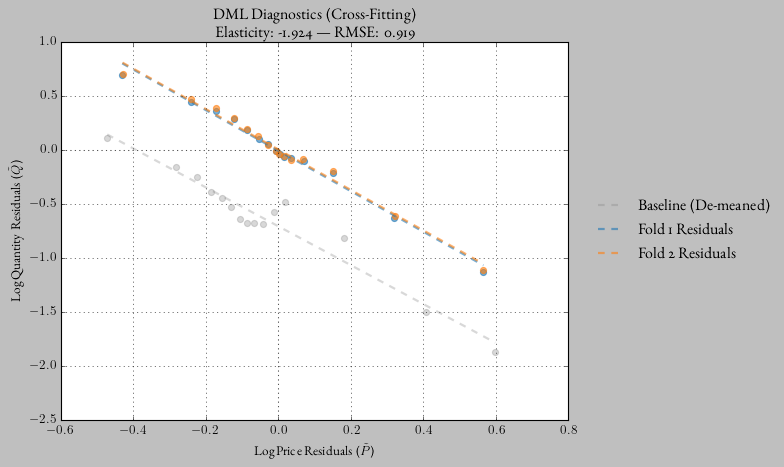

In [35]:
# ===== Robust: Report Result =====
fig, ax = plt.subplots(figsize=(10, 6))

plot_dml_diagnostics(
    df_raw=df_mdl,  # 原始数据, 用于画灰色背景
    dml_results=results,
    n_bins=15,
    ax=ax,
)

plt.grid()
plt.tight_layout()
plt.savefig("dml_diagnostics_final.pdf", bbox_inches="tight")
plt.show()


In [32]:
# ===== Robust: Calc MSE/RMSE Function =====

def calc_binned_metrics(dml_result_dict, n_bins=15):
    """
    【瞬时步骤】
    基于已有的残差数据, 先分箱取均值, 再计算 MSE/RMSE。

    Args:
        dml_result_dict: step1 返回的字典, 包含 'df_residuals' 和 'theta'
        n_bins: 分箱数量
    """
    df = dml_result_dict["df_residuals"].copy()
    theta = dml_result_dict["avg_dml_elast"]  # DML 估算出的弹性系数

    # 1. 分箱 (Binning)
    # 根据价格残差 (X轴) 进行等频分箱
    df["bin_id"] = pd.qcut(df["dLnP_res"], q=n_bins, duplicates="drop")

    # 2. 聚合 (Aggregation) -> 这就是 "De-noising" 的过程
    # 计算每个箱子内 X 和 Y 的均值
    bin_stats = (
        df.groupby("bin_id", observed=True)
        .agg(
            {
                "dLnP_res": "mean",  # Bin center X
                "dLnQ_res": "mean",  # Bin center Y
            }
        )
        .reset_index()
    )

    # 3. 预测 (Prediction on Bins)
    # 使用 DML 算出的 theta 来预测分箱后的点
    # 公式: y_pred = theta * x (因为残差均值为0, 理论截距为0)
    x_bins = bin_stats["dLnP_res"]
    y_true_bins = bin_stats["dLnQ_res"]
    y_pred_bins = x_bins * theta

    # 4. 计算指标 (Metrics)
    mse_binned = mean_squared_error(y_true_bins, y_pred_bins)
    rmse_binned = np.sqrt(mse_binned)

    # --- 打印汇报 ---
    print(f"{'=' * 40}")
    print(f"Evaluation on {n_bins} Aggregated Bins")
    print(f"{'=' * 40}")
    print(f"DML Elasticity (Theta) : {theta:.4f}")
    print(
        f"Binned MSE             : {mse_binned:.6f}"
    )  # 保留更多小数位, 因为它通常很小
    print(f"Binned RMSE            : {rmse_binned:.6f}")
    print(f"{'=' * 40}")

    return mse_binned, rmse_binned


In [33]:
# ===== Robust: Report MSE/RMSE =====
mse, rmse = calc_binned_metrics(results)


Evaluation on 15 Aggregated Bins
DML Elasticity (Theta) : -1.9237
Binned MSE             : 0.002293
Binned RMSE            : 0.047887
